In [1]:
%matplotlib inline

<div style='display: flex; justify-content: space-between; align-items: center; width: 100%;'>
    <h1 style='flex-grow: 1; margin-right: 120px; white-space: nowrap;'>THESE ARE NOT MY SHEEP YAS YAS YAS SKALEY</h1>
    <img src='https://upload.wikimedia.org/wikipedia/commons/7/78/Eindhoven_University_of_Technology_logo_new.png' alt='tue' style='height: 100px; flex-shrink: 0;'>
</div>

<div>
    <h3>Assignment 3 - Hydraulic Cross Section</h3>
    <p><strong>June 2024</strong></p>
    <p><strong>Ata Bekișoğlu</strong> - <i>1697048</i></p>
</div>

<!-- ya allah send help-->

# Abstract

### Table of Contents

---

# Introduction

---

# Problem Description

The problem at hand is modeling the laminar flow of a viscous fluid through a porous medium (e.g., a sponge) within a long channel. The porous medium is represented by binary images where each pixel is either "open" (allowing fluid flow) or  "closed" (impermeable to fluid flow). My main goal is to quantify the **hydraulic throughput** $ S $, a geometric parameter that remains independent of the fluid properties channel length and pressure drop using the relation:

$$
S = \frac{\mu L Q}{\Delta P}
\tag{1}
$$

Where $ Q $ is the volumetric flow rate, $ \mu $ is the fluid viscosity, $ L $ is the channel length, and $ \Delta P $ is the pressure drop. My task is to predict $ S $ from the binary cross-sectional images from the porous medium. 

---

# Making Sense of the Data
In this section, I  aim to explore the dimensional properties of the data, generate visualizations to aid with the general understanding of the problem at hand and explore the statistical properties that might help build better neural networks. 

The dataset consists of two `.npy` ([NumPy](https://numpy.org/)) with $ N = 1660 $ samples of $ 40 \times 40 $ pixel area images and hydraulic throughput $ S $ targets.

In [2]:
import numpy as np

X = np.load("data/pub_input.npy")
y = np.load("data/pub_out.npy")
print(X.shape, y.shape)

(1660, 40, 40) (1660,)



## Dimensionality, Homogeneity and Scaling
### Dimensionality
Dimensional homogeneity ensures that the quantities are consistent in terms of their SI units. Here, I analyze the dimensionality of the problem, apply scaling, and ensure homogeneity to accurately predict hydraulic throughput. The  variables in the problem have the following dimensions in SI units:
- Volumetric flow rate $ Q $, is measured in cubic meters per second [$ m^3s^{-1} $].
- Pressure drop $ \Delta P $, is measured in Pascals ($ Pa $), also equivalent to [$ kg \cdot m^{-1} \cdot s^{-2} $].
- Channel length $ L $, is measured in meters [$ m $].
- Fluid viscosity $ \mu $ is measured in Pascal-seconds ($ Pa \cdot s $) which is equivalent to [$ kg \cdot m^{-1} \cdot s^{-1} $].
- **Pixel area $ A $ is measured in square meters [$ m^2 $]**.
- **The hydraulic throughput $ S $ is calculated using (1) which gives**:

$$
S = \frac{
[kg \cdot m^{-1} \cdot s^{-1}] \cdot [m] \cdot [m^3 \cdot s^{-1}]}
{[kg \cdot m^{-1} \cdot s^{-2}]} = [m^4]
\tag{2}
$$

### Scaling
To make the fitting problem 1-degree homogeneous the target variable $ S $ is scaled by the square root to reduce its SI unit from $ m^4 $ to $ m^2 $. This ensures that the units of the target variable align with the input image units. 
$$
S_i' = \sqrt{S_i}
\tag{3}
$$
To apply this logic in Python:

In [3]:
y = np.sqrt(y)

## Visualizing the Problem
To better understand the dataset, several visualizations are performed, including visualizing some of the binary cross-section images along with their corresponding hydraulic throughput values, distribution of $ S $, and a density plot.

The basic properties of the hydraulic throughput:

In [21]:
print(f'Min: {np.min(y):0.2f}, \
        Max: {np.max(y):0.2f},\
        Mean: {np.mean(y):0.2f}, \
        Standard Deviation: {np.std(y):0.2f}, \
        Correlation Between Consecutive S: {np.corrcoef(y[:-1], y[1:])[0, 1]:0.2f}')

Min: 2.65,         Max: 554.82,        Mean: 110.99,         Standard Deviation: 144.51,         Correlation Between Consecutive S: 0.40


The hydraulic throughput values are spread out, with many values clustered around lower values indicated by the mean. The high standard deviation suggests substantial variability in the hydraulic throughput across different images. There is also a small amount of positive correlation between consecutive throughputs of cross-sections ($ S_i - S_{i-1} $) meaning there is a small influence between consecutive cross-sections. 



And, for the areas (total area per image):

In [5]:
total_area = X.sum(axis=(1, 2))
print(f'Min: {np.min(total_area):0.2f}, \
        Max: {np.max(total_area):0.2f},\
        Mean: {np.mean(total_area):0.2f}, \
        Standard Deviation: {np.std(total_area):0.2f}')

Min: 7.00,         Max: 1435.00,        Mean: 384.02,         Standard Deviation: 409.31


The total open area per image varies widely, indicating diverse cross-section porosity levels. The mean area of 384.02 pixels suggests that, on average, about half of the pixels in the images are open. The high standard deviation reflects significant heterogeneity in the distribution of open areas across the images.

**Binary Cross-Section Images**:

The first 5 examples from `X` are plotted and annotated with their corresponding hydraulic throughput $ S' $.

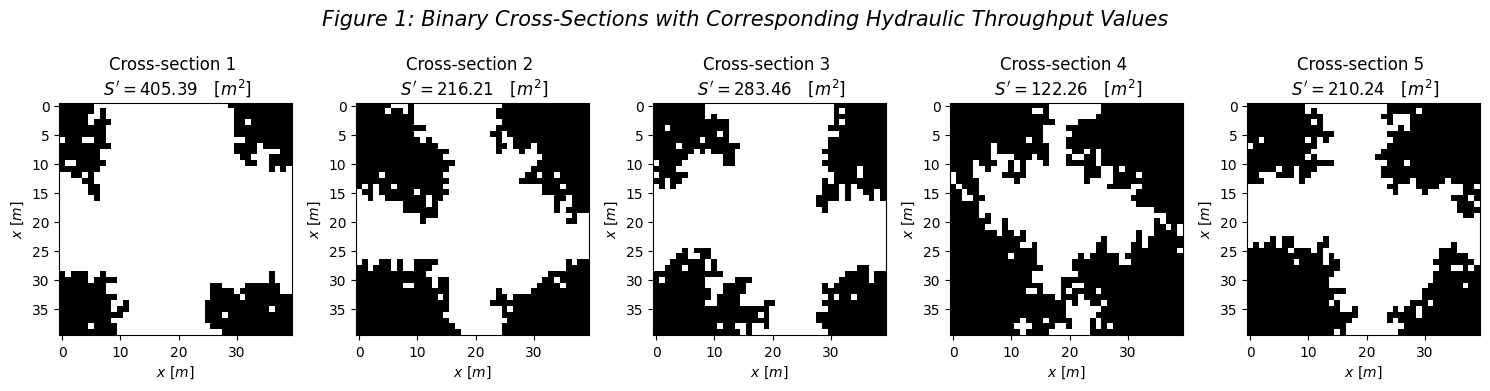

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i in range(5):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].set_title(f"Cross-section {i + 1} \n $ S' = {y[i]:.2f} \quad [m^2] $ ")
    axes[i].set_xlabel('$ x \ [m] $')
    axes[i].set_ylabel('$ x \ [m] $')

plt.suptitle('Figure 1: Binary Cross-Sections with Corresponding Hydraulic Throughput Values', fontsize=15, style='italic')
plt.tight_layout()
plt.show()

*Figure 1* shows five examples of open (white) and closed (black) pixels affecting the hydraulic throughput $ S $. Cross-sections with more continuous pathways for fluid flow tend to have higher $ S $ values, indicating greater hydraulic throughput.

**Distribution of Hydraulic Throughput Values & Density Plot of Hydraulic Throughput vs. Number of Open Pixels**:

A histogram is plotted to visualize the distribution of hydraulic throughput values (Figure 2). Additionally, the number of open pixels and how they correspond to $ S $ values is plotted (Figure 3) in a density plot.

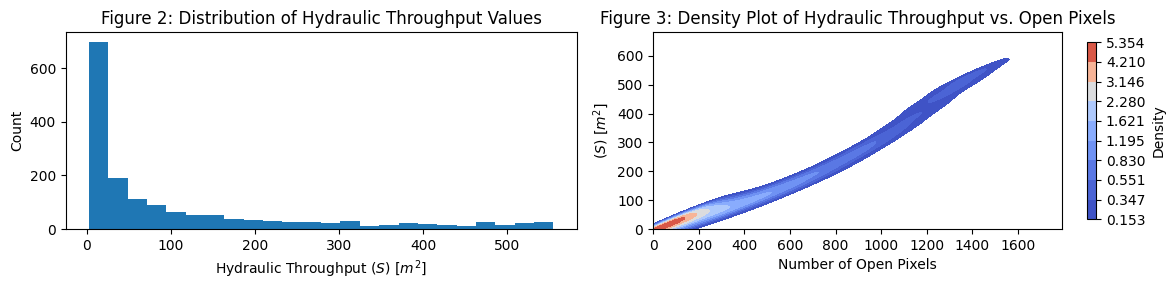

In [7]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# histogram of hydraulic throughput values
axes[0].hist(y, bins=24)
axes[0].set_xlabel('Hydraulic Throughput ($S$) $[m^2]$')
axes[0].set_ylabel('Count')
axes[0].set_title('Figure 2: Distribution of Hydraulic Throughput Values')

# hydraulic throughput vs. number of open pixels
dp = sns.kdeplot(x=total_area, y=y, cmap='coolwarm', fill=True, ax=axes[1])
axes[1].set_xlabel('Number of Open Pixels')
axes[1].set_ylabel('($S$) $[m^2]$')
axes[1].set_title('Figure 3: Density Plot of Hydraulic Throughput vs. Open Pixels')
axes[1].set_xlim(0)
axes[1].set_ylim(0)
plt.colorbar(dp.collections[-1], ax=axes[1], label='Density', shrink=0.9).ax.yaxis.offsetText.set_visible(False)

plt.tight_layout()
plt.show()

*Figure 2* shows that most hydraulic throughput $ S $ values are concentrated at the lower end. This indicates that higher $ S $ values are less frequent suggesting that many cross-sections have limited pathways for fluid flow, leading to lower hydraulic throughput.

*Figure 3* shows a positive correlation between the number of open pixels and hydraulic throughput. The highest density of points is around lower open pixel counts and lower $ S $ values, indicating that most cross-sections have fewer open pixels and consequently lower hydraulic throughput. As the number of open pixels increases, $ S $ also increases implying that cross-sections with more open pixels provide more continuous pathways for fluid flow, resulting in higher hydraulic throughput. The concentration of lower $ S $ values in *Figure 2* aligns with the scatter plot, indicating that many images have fewer open pixels, hence lower hydraulic throughput.

# Exploring Symmetries in the Problem



\
\
\



For the invariance properties, we have the following criteria:
- Cannot disrupt the white pixel clusters
- Cannot lose any open pixels
- IMPLEMENT AN `assert` METHOD THAT CHECKS FOR THE WHITE PIXEL COUNT PER SYMMETRY
- Talk about the positive correlation between $S_{i} - S_{i-1} $ (0.40) from the previous section.


Here talk about all the considered symmetries and which ones can work and which ones cannot:
- Rotational symmetry over $ 90 \degree $ intervals
- Flip symmetry over $ x $ and $ y $ axes
- General permutations -cannot work
- Translational symmetry
  - In the case of wrapping might disrupt open pixel clusters
  - Might need padding
- Scaling -cannot work

- 